# Image Captioning
Generating Captions for images

# Steps
### Data Collection
### Data Cleaning
### Loading the training set
### Data Preprocessing--images
### Data Preprocessing--Captions
### Data Preperation using Generator Function
### Word Embeddings
### Model Architecture 
### Inference
### Evaluation

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM

from tensorflow.keras.layers import add

In [107]:
# Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [108]:
captions= readTextFile("Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions=captions.split("\n")[:-1]
print(len(captions))

40460


###### so we have totally 40460 captions in our dataset

In [109]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [110]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [111]:
captions[1]

'1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .'

In [112]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

#### Create a dictionary which maps with the list of captions

In [113]:
descriptions={}
for i in captions:
    first,second=i.split('\t')
    img_name=first.split(".")[0]
    # if the image id is already present or not
    if img_name in descriptions:
        descriptions[img_name].append(second)
    else:
        descriptions[img_name]=[second]

In [114]:
descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

# Data Cleaning

In [115]:
#Don't remove stopwords and don't do stemmming as it is required in the end while genrating the text.
import re
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)#if not alphabet replace with space
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [116]:
clean_text("A cat is sitting### over the house @@3####")

'cat is sitting over the house'

In [117]:
 # clean all captions 
for key,captions_list in descriptions.items():
    for i in range(len(captions_list)):
        captions_list[i]=clean_text(captions_list[i])
            

In [118]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [119]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

# Vocabulary

In [120]:
#set of all unique words the model can predict
import json
descriptions=None
with open('descriptions_1.txt','r') as f:
    descriptions=f.read()
json_string=descriptions.replace("'","\"")
descriptions=json.loads(json_string)

In [121]:
print(descriptions)

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin'], '1001773457_577c3a7d70': ['black dog and spotted dog are fighting', 'black dog and tri colored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other'], '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl', 'little girl is sitting in front of large painted rainbow', 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it', 'there is girl with pigtails sitting in front of rainbow painting', 'young girl with pigtails painting outside i

In [122]:
print(type(descriptions))

<class 'dict'>


In [123]:
# vocab
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [124]:
print("vocab size is",len(vocab))

vocab size is 8424


In [125]:
vocab

{'embracing',
 'beads',
 'eastern',
 'pleople',
 'investigates',
 'nerf',
 'sound',
 'disks',
 'what',
 'shorter',
 'banging',
 'feild',
 'redheaded',
 'captures',
 'surfboarding',
 'fluffy',
 'bluejean',
 'oars',
 'coyotes',
 'soccor',
 'staffordshire',
 'woooden',
 'worshipping',
 'soundproof',
 'boods',
 'antlers',
 'chopsticks',
 'devotion',
 'positions',
 'fight',
 'faithful',
 'bundled',
 'dong',
 'noy',
 'defense',
 'silhouettes',
 'housekeeping',
 'falling',
 'rappels',
 'damp',
 'seawall',
 'bean',
 'following',
 'messy',
 'checkered',
 'chart',
 'ever',
 'dug',
 'amused',
 'redskins',
 'perpendicular',
 'conversation',
 'serve',
 'flowery',
 'boarders',
 'strand',
 'kayak',
 'platform',
 'coat',
 'cornfield',
 'ques',
 'marvel',
 'nipples',
 'sombody',
 'pigeon',
 'grips',
 'picking',
 'pencils',
 'town',
 'brilliant',
 'casts',
 'afternoon',
 'archer',
 'oiled',
 'currents',
 'colapsable',
 'pieces',
 'hotrod',
 'canes',
 'coached',
 'drooling',
 'nibbling',
 'modifications'

In [126]:
# Total no of words across all the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("total words across all the sentences are",len(total_words))

total words across all the sentences are 373837


In [22]:
# Filter words from the vocab according to certain threshold frequency

In [23]:
import collections 
counter=collections.Counter(total_words)
freq_count=dict(counter)
print(len(freq_count.keys()))
print(freq_count)

8424
{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'pain

In [24]:
#Sort the dictionary according to the frequency count
sorted_freq_count=sorted(freq_count.items(),reverse=True,key=lambda x:x[1])#lambda funcction is used to sort the words

In [25]:
sorted_freq_count

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [26]:
#Filter
threshold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_count]

In [27]:
sorted_freq_count

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [28]:
print(len(total_words))

1845


##### Firstly we have 373837 words and then  total unique words from those words are 8424 but total words with freq_count having threshold is 1845.So this 1845 is our vocab size.

### Prepare Train/Test Data

In [29]:
train_file_data=readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")

In [30]:
print(train_file_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [31]:
test_file_data=readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [32]:
print(test_file_data)

3385593926_d3e9c21170.jpg
2677656448_6b7e7702af.jpg
311146855_0b65fdb169.jpg
1258913059_07c613f7ff.jpg
241347760_d44c8d3a01.jpg
2654514044_a70a6e2c21.jpg
2339106348_2df90aa6a9.jpg
256085101_2c2617c5d0.jpg
280706862_14c30d734a.jpg
3072172967_630e9c69d0.jpg
3482062809_3b694322c4.jpg
1167669558_87a8a467d6.jpg
2847615962_c330bded6e.jpg
3344233740_c010378da7.jpg
2435685480_a79d42e564.jpg
3110649716_c17e14670e.jpg
2511019188_ca71775f2d.jpg
2521770311_3086ca90de.jpg
2723477522_d89f5ac62b.jpg
2218609886_892dcd6915.jpg
3745451546_fc8ec70cbd.jpg
2844018783_524b08e5aa.jpg
3100251515_c68027cc22.jpg
2207244634_1db1a1890b.jpg
2943023421_e297f05e11.jpg
3286822339_5535af6b93.jpg
2479652566_8f9fac8af5.jpg
1394368714_3bc7c19969.jpg
872622575_ba1d3632cc.jpg
2309860995_c2e2a0feeb.jpg
241347204_007d83e252.jpg
3502343542_f9b46688e5.jpg
757332692_6866ae545c.jpg
2748729903_3c7c920c4d.jpg
494792770_2c5f767ac0.jpg
3213992947_3f3f967a9f.jpg
2295750198_6d152d7ceb.jpg
2358898017_24496b80e8.jpg
3222055946_45f7293bb

In [33]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]

In [34]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [35]:
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [36]:
test

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0',
 '3482062809_3b694322c4',
 '1167669558_87a8a467d6',
 '2847615962_c330bded6e',
 '3344233740_c010378da7',
 '2435685480_a79d42e564',
 '3110649716_c17e14670e',
 '2511019188_ca71775f2d',
 '2521770311_3086ca90de',
 '2723477522_d89f5ac62b',
 '2218609886_892dcd6915',
 '3745451546_fc8ec70cbd',
 '2844018783_524b08e5aa',
 '3100251515_c68027cc22',
 '2207244634_1db1a1890b',
 '2943023421_e297f05e11',
 '3286822339_5535af6b93',
 '2479652566_8f9fac8af5',
 '1394368714_3bc7c19969',
 '872622575_ba1d3632cc',
 '2309860995_c2e2a0feeb',
 '241347204_007d83e252',
 '3502343542_f9b46688e5',
 '757332692_6866ae545c',
 '2748729903_3c7c920c4d',
 '494792770_2c5f767ac0',
 '3213992947_3f3f967a9f',
 '2295750198_6d152d7ceb',
 '2358898017_24496b80e8',
 '3222055946_45f7293

In [37]:
# Prepare descriptions for the training data
#Add <start> and <end> token to our training data in order to end at a particular point
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append='startseq ' + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [38]:
train_descriptions# So we have successfully added start and end sequence

{'2513260012_03d33305cf': ['startseq black dog is running after white dog in the snow endseq',
  'startseq black dog chasing brown dog through snow endseq',
  'startseq two dogs chase each other across the snowy ground endseq',
  'startseq two dogs play together in the snow endseq',
  'startseq two dogs running through low lying body of water endseq'],
 '2903617548_d3e38d7f88': ['startseq little baby plays croquet endseq',
  'startseq little girl plays croquet next to truck endseq',
  'startseq the child is playing croquette by the truck endseq',
  'startseq the kid is in front of car with put and ball endseq',
  'startseq the little boy is playing with croquet hammer and ball beside the car endseq'],
 '3338291921_fe7ae0c8f8': ['startseq brown dog in the snow has something hot pink in its mouth endseq',
  'startseq brown dog in the snow holding pink hat endseq',
  'startseq brown dog is holding pink shirt in the snow endseq',
  'startseq dog is carrying something pink in its mouth whil

### Transfer Learning
### Images-->Features
### Text-->Features

### Step-1:Image Feature Extraction

In [39]:
from keras.applications import ResNet50
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [40]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [41]:
from keras import Model
new_model=Model(model.input,model.layers[-2].output)

In [42]:
#Extract Image Feature Vectors
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)#for reshaping
    #Normalization
    img=preprocess_input(img)
    return img

In [43]:
img=preprocess_img("Flickr_Data/Images/"+"1000268201_693b08cb0e.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


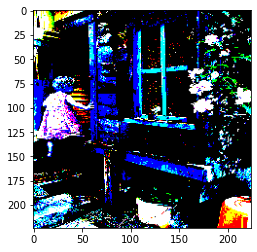

In [44]:
plt.imshow(img[0])
plt.show()

In [45]:
 def encode_image(img):
        img=preprocess_img(img)
        feature_vector=new_model.predict(img)
        feature_vector=feature_vector.reshape((-1,))
        return feature_vector

In [46]:
encode_image("Flickr_Data/Images/"+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 1s 884ms/step


array([0.06535926, 0.16782555, 0.3251761 , ..., 0.05107139, 0.32821193,
       1.0043361 ], dtype=float32)

In [47]:
encoding_train={}

In [48]:

#image_id-->feature_vector extracted from Resnet Image
from time import time
start=time()
IMG_PATH="Flickr_Data/Images/"
for ix,img_id in enumerate(train):
    img_path=IMG_PATH+"/"+img_id+'.jpg'
    encoding_train[img_id]=encode_image(img_path)
    if ix%100==0:
        print("Encoding in Process Time step"+str(ix))
print("Total Time Taken:",time()-start)

1/1 [==============================] - 0s 177ms/step
Encoding in Process Time step0
1/1 [==============================] - 0s 172ms/step
Encoding in Process Time step100
1/1 [==============================] - 0s 161ms/step
Encoding in Process Time step200
1/1 [==============================] - 0s 180ms/step
Encoding in Process Time step300
1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 180ms/step
Encoding in Process Time step400
1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 196ms/step
Encoding in Process Time step500
1/1 [==============================] - 0s 177ms/step
Encoding in Process Time step600
1/1 [==============================] - 0s 188ms/step
Encoding in Process Time step700
1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 180ms/step
Encoding in Process Time step800
1/1 [==============================] - 0s 180ms/step
Encoding in Process Time step900
1/1 [==============================] - 0s 188ms/step
Encoding in Process Time step1000
1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 195ms/step
Encoding in Process Time step1100
1/1 [==============================] - 0s 196ms/step
Encoding in Process Time step1200
1/1 [==============================] - 0s 188ms/step
Encoding in Process Time step1300
1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 197ms/step
Encoding in Process Time step1400
1/1 [==============================] - 0s 194ms/step
Encoding in Process Time step1500
1/1 [==============================] - 0s 186ms/step
Encoding in Process Time step1600
1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 202ms/step
Encoding in Process Time step1700
1/1 [==============================] - 0s 194ms/step
Encoding in Process Time step1800
1/1 [==============================] - 0s 210ms/step
Encoding in Process Time step1900
1/1 [==============================] - 0s 212ms/step


1/1 [==============================] - 0s 219ms/step
Encoding in Process Time step2000
1/1 [==============================] - 0s 202ms/step
Encoding in Process Time step2100
1/1 [==============================] - 0s 219ms/step
Encoding in Process Time step2200
1/1 [==============================] - 0s 234ms/step
Encoding in Process Time step2300


1/1 [==============================] - 0s 227ms/step
Encoding in Process Time step2400
1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 243ms/step
Encoding in Process Time step2500
1/1 [==============================] - 0s 236ms/step
Encoding in Process Time step2600
1/1 [==============================] - 0s 239ms/step
Encoding in Process Time step2700
1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 261ms/step
Encoding in Process Time step2800
1/1 [==============================] - 0s 281ms/step
Encoding in Process Time step2900
1/1 [==============================] - 0s 277ms/step
Encoding in Process Time step3000
1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 293ms/step
Encoding in Process Time step3100
1/1 [==============================] - 0s 431ms/step
Encoding in Process Time step3200
1/1 [==============================] - 0s 433ms/step
Encoding in Process Time step3300
1/1 [==============================] - 1s 523ms/step


1/1 [==============================] - 0s 466ms/step
Encoding in Process Time step3400
1/1 [==============================] - 1s 503ms/step
Encoding in Process Time step3500
1/1 [==============================] - 1s 529ms/step
Encoding in Process Time step3600
1/1 [==============================] - 1s 591ms/step


1/1 [==============================] - 1s 541ms/step
Encoding in Process Time step3700
1/1 [==============================] - 1s 546ms/step
Encoding in Process Time step3800
1/1 [==============================] - 1s 580ms/step
Encoding in Process Time step3900
1/1 [==============================] - 1s 601ms/step


1/1 [==============================] - 1s 602ms/step
Encoding in Process Time step4000
1/1 [==============================] - 1s 634ms/step
Encoding in Process Time step4100
1/1 [==============================] - 1s 688ms/step
Encoding in Process Time step4200
1/1 [==============================] - 1s 652ms/step


1/1 [==============================] - 1s 633ms/step
Encoding in Process Time step4300
1/1 [==============================] - 1s 651ms/step
Encoding in Process Time step4400
1/1 [==============================] - 1s 702ms/step
Encoding in Process Time step4500
1/1 [==============================] - 1s 689ms/step
Encoding in Process Time step4600
1/1 [==============================] - 1s 693ms/step


1/1 [==============================] - 1s 682ms/step
Encoding in Process Time step4700
1/1 [==============================] - 1s 728ms/step


1/1 [==============================] - 1s 750ms/step
Encoding in Process Time step4800
1/1 [==============================] - 1s 770ms/step
Encoding in Process Time step4900
1/1 [==============================] - 1s 774ms/step
Encoding in Process Time step5000
1/1 [==============================] - 1s 763ms/step


1/1 [==============================] - 1s 736ms/step
Encoding in Process Time step5100
1/1 [==============================] - 1s 724ms/step
Encoding in Process Time step5200
1/1 [==============================] - 1s 751ms/step
Encoding in Process Time step5300
1/1 [==============================] - 1s 779ms/step


1/1 [==============================] - 1s 786ms/step
Encoding in Process Time step5400
1/1 [==============================] - 1s 788ms/step
Encoding in Process Time step5500
1/1 [==============================] - 1s 751ms/step
Encoding in Process Time step5600
1/1 [==============================] - 1s 747ms/step


1/1 [==============================] - 1s 759ms/step
Encoding in Process Time step5700
1/1 [==============================] - 1s 861ms/step
Encoding in Process Time step5800
1/1 [==============================] - 1s 806ms/step
Encoding in Process Time step5900
1/1 [==============================] - 1s 814ms/step


1/1 [==============================] - 1s 833ms/step
Total Time Taken: 7827.818007946014


In [49]:
#Store everything to the desk
import pickle
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [50]:
encoding_test={}
from time import time
start=time()
IMG_PATH="Flickr_Data/Images/"
for ix,img_id in enumerate(test):
    img_path=IMG_PATH+"/"+img_id+'.jpg'
    encoding_test[img_id]=encode_image(img_path)
    if ix%100==0:
        print("Encoding in Process Time step",ix)
print("Total Time Taken:",time()-start)

1/1 [==============================] - 1s 820ms/step
Encoding in Process Time step 0
1/1 [==============================] - 1s 888ms/step
Encoding in Process Time step 100
1/1 [==============================] - 1s 914ms/step
Encoding in Process Time step 200
1/1 [==============================] - 1s 896ms/step
Encoding in Process Time step 300
1/1 [==============================] - 1s 914ms/step


1/1 [==============================] - 1s 954ms/step
Encoding in Process Time step 400
1/1 [==============================] - 1s 954ms/step


1/1 [==============================] - 1s 957ms/step
Encoding in Process Time step 500
1/1 [==============================] - 1s 1s/step
Encoding in Process Time step 600
1/1 [==============================] - 1s 1s/step
Encoding in Process Time step 700
1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step
Encoding in Process Time step 800
1/1 [==============================] - 1s 1s/step
Encoding in Process Time step 900
1/1 [==============================] - 1s 1s/step
Total Time Taken: 1067.656751871109


In [51]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

## Data Preprocessing-Image Captions

In [53]:
vocab_size=len(total_words)

In [54]:
vocab_size

1845

In [55]:
word_to_idx={}
idx_to_word={}

In [56]:
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [57]:
word_to_idx#Word to index dictionary

{'in': 1,
 'the': 2,
 'on': 3,
 'is': 4,
 'and': 5,
 'dog': 6,
 'with': 7,
 'man': 8,
 'of': 9,
 'two': 10,
 'white': 11,
 'black': 12,
 'boy': 13,
 'are': 14,
 'woman': 15,
 'girl': 16,
 'to': 17,
 'wearing': 18,
 'at': 19,
 'people': 20,
 'water': 21,
 'red': 22,
 'young': 23,
 'brown': 24,
 'an': 25,
 'his': 26,
 'blue': 27,
 'dogs': 28,
 'running': 29,
 'through': 30,
 'playing': 31,
 'while': 32,
 'shirt': 33,
 'down': 34,
 'standing': 35,
 'ball': 36,
 'little': 37,
 'grass': 38,
 'snow': 39,
 'child': 40,
 'person': 41,
 'jumping': 42,
 'over': 43,
 'three': 44,
 'front': 45,
 'sitting': 46,
 'holding': 47,
 'up': 48,
 'field': 49,
 'small': 50,
 'by': 51,
 'large': 52,
 'green': 53,
 'one': 54,
 'group': 55,
 'yellow': 56,
 'her': 57,
 'walking': 58,
 'children': 59,
 'men': 60,
 'into': 61,
 'air': 62,
 'beach': 63,
 'near': 64,
 'mouth': 65,
 'jumps': 66,
 'another': 67,
 'for': 68,
 'street': 69,
 'runs': 70,
 'its': 71,
 'from': 72,
 'riding': 73,
 'stands': 74,
 'as': 75,


In [58]:
idx_to_word#Index to word dictionary

{1: 'in',
 2: 'the',
 3: 'on',
 4: 'is',
 5: 'and',
 6: 'dog',
 7: 'with',
 8: 'man',
 9: 'of',
 10: 'two',
 11: 'white',
 12: 'black',
 13: 'boy',
 14: 'are',
 15: 'woman',
 16: 'girl',
 17: 'to',
 18: 'wearing',
 19: 'at',
 20: 'people',
 21: 'water',
 22: 'red',
 23: 'young',
 24: 'brown',
 25: 'an',
 26: 'his',
 27: 'blue',
 28: 'dogs',
 29: 'running',
 30: 'through',
 31: 'playing',
 32: 'while',
 33: 'shirt',
 34: 'down',
 35: 'standing',
 36: 'ball',
 37: 'little',
 38: 'grass',
 39: 'snow',
 40: 'child',
 41: 'person',
 42: 'jumping',
 43: 'over',
 44: 'three',
 45: 'front',
 46: 'sitting',
 47: 'holding',
 48: 'up',
 49: 'field',
 50: 'small',
 51: 'by',
 52: 'large',
 53: 'green',
 54: 'one',
 55: 'group',
 56: 'yellow',
 57: 'her',
 58: 'walking',
 59: 'children',
 60: 'men',
 61: 'into',
 62: 'air',
 63: 'beach',
 64: 'near',
 65: 'mouth',
 66: 'jumps',
 67: 'another',
 68: 'for',
 69: 'street',
 70: 'runs',
 71: 'its',
 72: 'from',
 73: 'riding',
 74: 'stands',
 75: 'as',


In [59]:
idx_to_word[1846]="startseq"
idx_to_word[1847]="endseq"
word_to_idx["startseq"]=1846
word_to_idx['endseq']=1847

In [60]:
vocab_size=len(word_to_idx)+1
print("Vocab size:",vocab_size)

Vocab size: 1848


In [61]:
maxlen=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        maxlen=max(maxlen,len(cap.split(" ")))

In [62]:
print("maximum length of the sentence in the training data:",maxlen)

maximum length of the sentence in the training data: 35


## Data Loader(Generator)

In [62]:
def data_generator(train_descriptions,encoding_train,word_to_idx,maxlen,batch_size):
    x1,x2,y=[],[],[]
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            photo=encoding_train[key]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for  i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    #0 denote padding word
                    xi=pad_sequences([xi],maxlen=maxlen,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                if n==batch_size:
                    yield [[np.array(x1),np.array(x2)],np.array(y)]
                    x1,x2,y=[],[],[]
                    n=0

## Word Embeddings

In [63]:
f=open("./glove.6B.50d.txt",encoding='utf8')

In [64]:
embedding_index={}
for line in f:
    values=line.split()
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding 
f.close()

In [65]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim ))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix

In [66]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

## Model Architecture

In [67]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [68]:
#caption as input
input_captions=Input(shape=(maxlen,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [69]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

In [70]:
#Combined model
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [71]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [72]:
model.layers[2].set_weights([embedding_matrix])

In [73]:
model.layers[2].trainable=False

In [74]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [75]:
epochs=10
batch_size=3
steps=len(train_descriptions)//batch_size
def train():
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoding_train,word_to_idx,maxlen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [76]:
train()

C:\Users\wwwka\AppData\Local\Temp/ipykernel_15256/3308876229.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


2000/2000 [==============================] - 1841s 921ms/step - loss: 2.7824


In [48]:
model=load_model('./model_weights/model_9.h5')


## Predictions

In [63]:
def predict_caption(photo):
    in_text='startseq'
    for i in range(maxlen):
        sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence],maxlen=maxlen,padding='post')
        ypred=model.predict([photo,sequence])
        ypred=ypred.argmax()#gives word with maximum probability--greedy sampling
        word=idx_to_word[ypred]
        in_text+=' '+word
        if word=='endseq':
            break
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 24ms/step
woman in black shirt and black shirt is standing in front of brick building


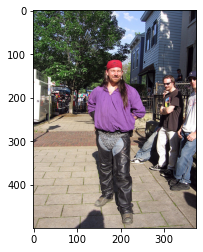

In [64]:
#pick some random images and see results
photo_2048=encode_image("Flickr_Data/Images/"+"2501968935_02f2cd8079.jpg").reshape((1,2048))
i=plt.imread("Flickr_Data/Images/"+"2501968935_02f2cd8079.jpg")
caption=predict_caption(photo_2048)
plt.imshow(i)
print(caption)

In [80]:
encoding_test

{'3385593926_d3e9c21170': array([0.33316895, 0.3834777 , 0.07253428, ..., 0.9083219 , 0.35600525,
        1.0914083 ], dtype=float32),
 '2677656448_6b7e7702af': array([0.29441997, 0.09479236, 0.70218074, ..., 0.01987061, 0.2909238 ,
        0.1095423 ], dtype=float32),
 '311146855_0b65fdb169': array([0.01134307, 0.08777494, 0.14328428, ..., 0.030065  , 1.1856292 ,
        0.06956816], dtype=float32),
 '1258913059_07c613f7ff': array([0.04770134, 1.4354631 , 0.10770518, ..., 0.13343848, 0.11505937,
        2.0496497 ], dtype=float32),
 '241347760_d44c8d3a01': array([0.06552826, 6.6828294 , 0.31763467, ..., 0.06200406, 0.03742834,
        0.0452251 ], dtype=float32),
 '2654514044_a70a6e2c21': array([1.9562049 , 0.04316816, 0.11143857, ..., 0.02008335, 0.68325466,
        0.43294114], dtype=float32),
 '2339106348_2df90aa6a9': array([0.08876374, 1.1927893 , 0.07676519, ..., 0.01899941, 0.13417563,
        0.13799481], dtype=float32),
 '256085101_2c2617c5d0': array([0.61918074, 0.5904769 , 0

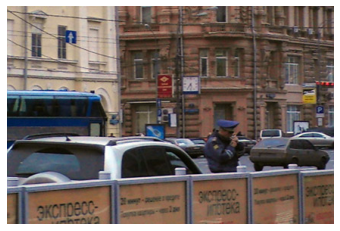

1/1 [==============================] - 0s 41ms/step
two people are standing in the back of car


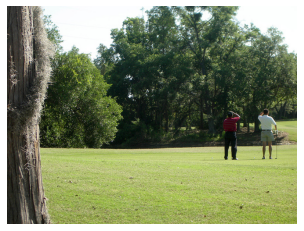

1/1 [==============================] - 0s 25ms/step
man in black shirt and black shirt is standing in the grass


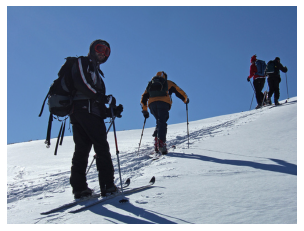

1/1 [==============================] - 0s 34ms/step
two people are walking down snowy hill


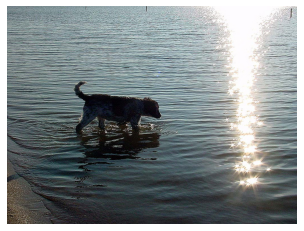

1/1 [==============================] - 0s 23ms/step
dog is running through the water


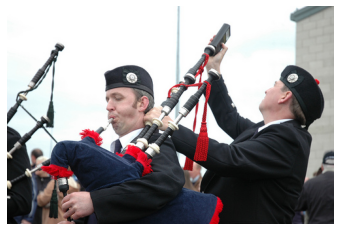

1/1 [==============================] - 0s 38ms/step
man in black shirt and black helmet is standing in front of large building


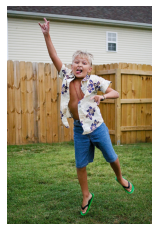

1/1 [==============================] - 0s 23ms/step
boy in blue shirt and blue shorts is jumping on the grass


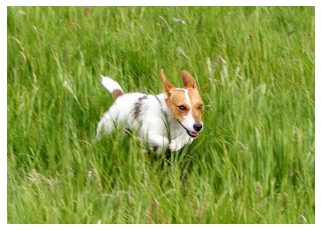

1/1 [==============================] - 0s 31ms/step
dog running through field of grass


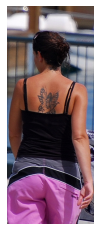

1/1 [==============================] - 0s 29ms/step
little girl in pink shirt is sitting on the phone


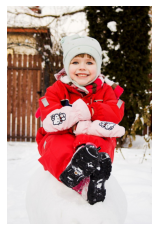

1/1 [==============================] - 0s 24ms/step
child in red coat is playing with water


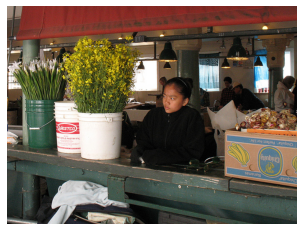

1/1 [==============================] - 0s 24ms/step
man in black shirt is sitting on the lap with his feet open


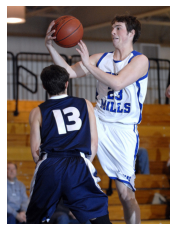

1/1 [==============================] - 0s 23ms/step
basketball player dribbles basketball


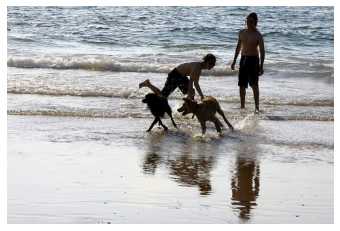

1/1 [==============================] - 0s 24ms/step
three people are walking along the beach


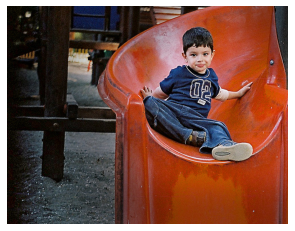

1/1 [==============================] - 0s 35ms/step
little boy in blue shirt is sitting on the floor


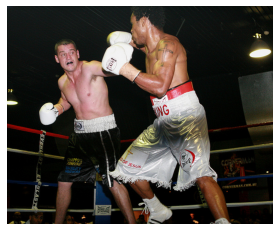

1/1 [==============================] - 0s 26ms/step
man in white shirt is leaping another wrestler


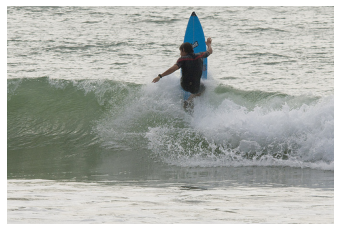

1/1 [==============================] - 0s 40ms/step
surfer in wetsuit riding wave


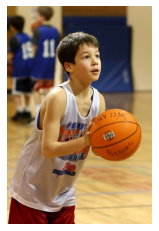

1/1 [==============================] - 0s 26ms/step
basketball player dribbles basketball


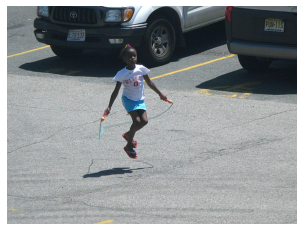

1/1 [==============================] - 0s 28ms/step
boy in black shirt and black pants is walking on the sidewalk


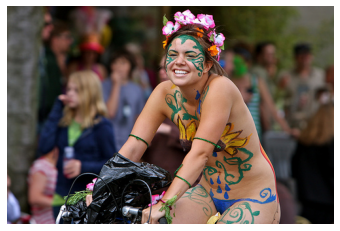

1/1 [==============================] - 0s 23ms/step
girl in red shirt and black hat is standing on the grass


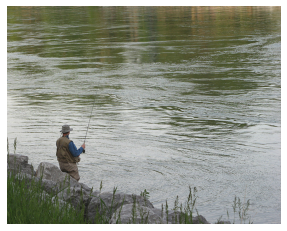

1/1 [==============================] - 0s 24ms/step
man is standing on the edge of the water


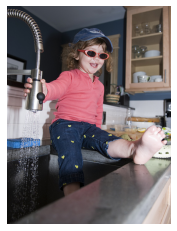

1/1 [==============================] - 0s 23ms/step
boy in pajamas is sitting on bed with his hands raised


In [82]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(IMG_PATH+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)